# My first Jupyter notebook

 A little bit late,huh. Let's start by generating some data.

In [1]:
#First, generate some fake categorization data, under a logistic model
set.seed(1234)
#Set parameters
gmean = 0
cat = .1
block = .3
catblock = .3

#Create design
cats = 0:1
blocks = 0:9
design = expand.grid(cats, blocks)
design$Var3 = design[, 1]*design[, 2]

#Generate data with normal noise
design = cbind(design, Var4 = as.matrix(design) %*% array(c(cat, block, catblock), dim = c(3, 1)) + gmean)
replicates = 30
data = do.call('rbind', sapply(1:replicates, function(x) data.frame(sub = x, design[, 1:2], logodds = design[, 4]+rnorm(nrow(design), 0, sd = .5)), simplify = F))

#calculate probabilities
data$prob = 1/(1+exp(-data$logodds))
names(data) = c('subject', 'category', 'block', 'logodds', 'pcorrect')
summary(data)

    subject        category       block        logodds           pcorrect     
 Min.   : 1.0   Min.   :0.0   Min.   :0.0   Min.   :-1.3661   Min.   :0.2032  
 1st Qu.: 8.0   1st Qu.:0.0   1st Qu.:2.0   1st Qu.: 0.8078   1st Qu.:0.6916  
 Median :15.5   Median :0.5   Median :4.5   Median : 1.8169   Median :0.8602  
 Mean   :15.5   Mean   :0.5   Mean   :4.5   Mean   : 2.0644   Mean   :0.8084  
 3rd Qu.:23.0   3rd Qu.:1.0   3rd Qu.:7.0   3rd Qu.: 2.9696   3rd Qu.:0.9512  
 Max.   :30.0   Max.   :1.0   Max.   :9.0   Max.   : 6.7079   Max.   :0.9988  

Visualize the data.

Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 3.6.3"


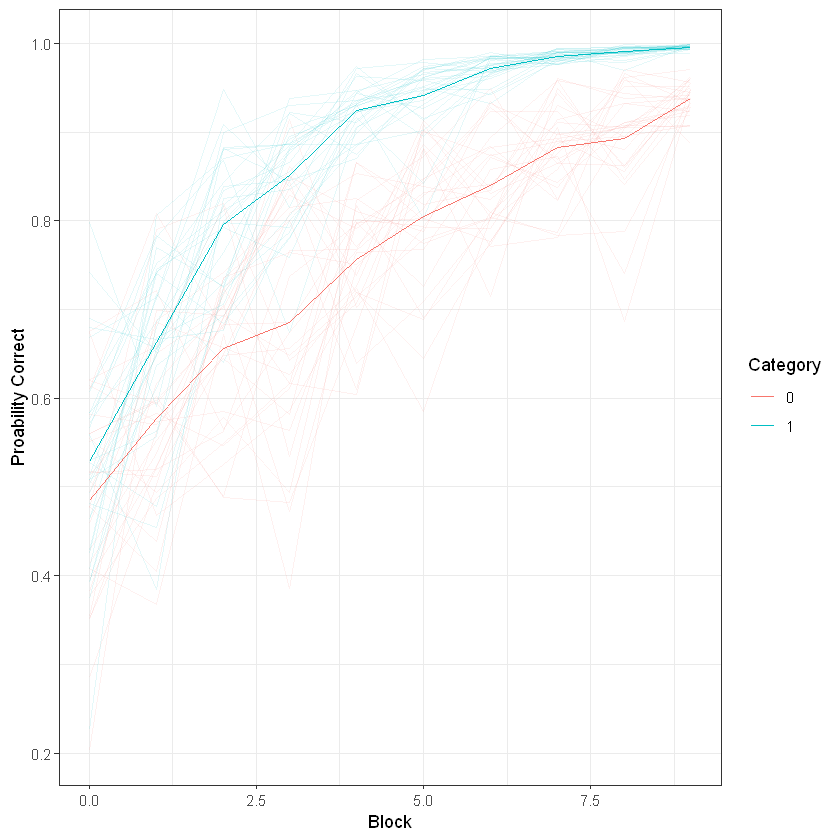

In [2]:
require(ggplot2)
ggplot(data, aes(x = block, y = pcorrect, colour = as.factor(category))) + 
geom_line(aes(group = interaction(category, subject)), alpha = .1) + 
stat_summary(fun.data = 'mean_se', geom = 'line') +
theme_bw() + labs(x = 'Block', y = 'Proability Correct', colour = 'Category')

Tweak the qnorm function to adjust perfect proportions (0 and 1).

In [3]:
adj_qnorm = function(p, adj = min(p[p!=0])/2){
  p[p == 0] = p[p == 0]+adj
  p[p == 1] = p[p == 1]-adj
  return(qnorm(p))
}

Here's the trick: we have to designate a target category (our task is not really a 2AF, because it presents a single stimulus). So, S and N trials are defined taking the target category into account. Let's use category 0 as the reference.

In [6]:
#Transformation of p(correct) of the non-target category to false alarms (1-p(correct))
data$sdt = ifelse(data$category == 0, data$pcorrect, 1-data$pcorrect)
#Now transform
data$zsdt = adj_qnorm(data$sdt)
#The final step involves the calculation of d prime, as z(H)-z(FA)
dtable = data[data$category == 0, ]
dim(dtable) #half the data is here
dtable$dprime = dtable$zsdt-data$zsdt[data$category == 1] #note how we use the other half of the data
#Similarly, we can calculate bias as -[z(H)+z(FA)]/2
dtable$criterion = -(dtable$zsdt+data$zsdt[data$category == 1])/2
summary(dtable)

[1] 300   7

    subject        category     block        logodds           pcorrect     
 Min.   : 1.0   Min.   :0   Min.   :0.0   Min.   :-1.3661   Min.   :0.2032  
 1st Qu.: 8.0   1st Qu.:0   1st Qu.:2.0   1st Qu.: 0.5815   1st Qu.:0.6414  
 Median :15.5   Median :0   Median :4.5   Median : 1.3552   Median :0.7950  
 Mean   :15.5   Mean   :0   Mean   :4.5   Mean   : 1.3350   Mean   :0.7518  
 3rd Qu.:23.0   3rd Qu.:0   3rd Qu.:7.0   3rd Qu.: 2.0673   3rd Qu.:0.8877  
 Max.   :30.0   Max.   :0   Max.   :9.0   Max.   : 3.5128   Max.   :0.9710  
      sdt              zsdt             dprime         criterion      
 Min.   :0.2032   Min.   :-0.8301   Min.   :-1.316   Min.   :-0.4082  
 1st Qu.:0.6414   1st Qu.: 0.3622   1st Qu.: 1.160   1st Qu.: 0.1819  
 Median :0.7950   Median : 0.8238   Median : 2.321   Median : 0.3549  
 Mean   :0.7518   Mean   : 0.7826   Mean   : 2.259   Mean   : 0.3470  
 3rd Qu.:0.8877   3rd Qu.: 1.2143   3rd Qu.: 3.331   3rd Qu.: 0.5383  
 Max.   :0.9710   Max.   : 1.8964  

Finally, plot the SDT indexes

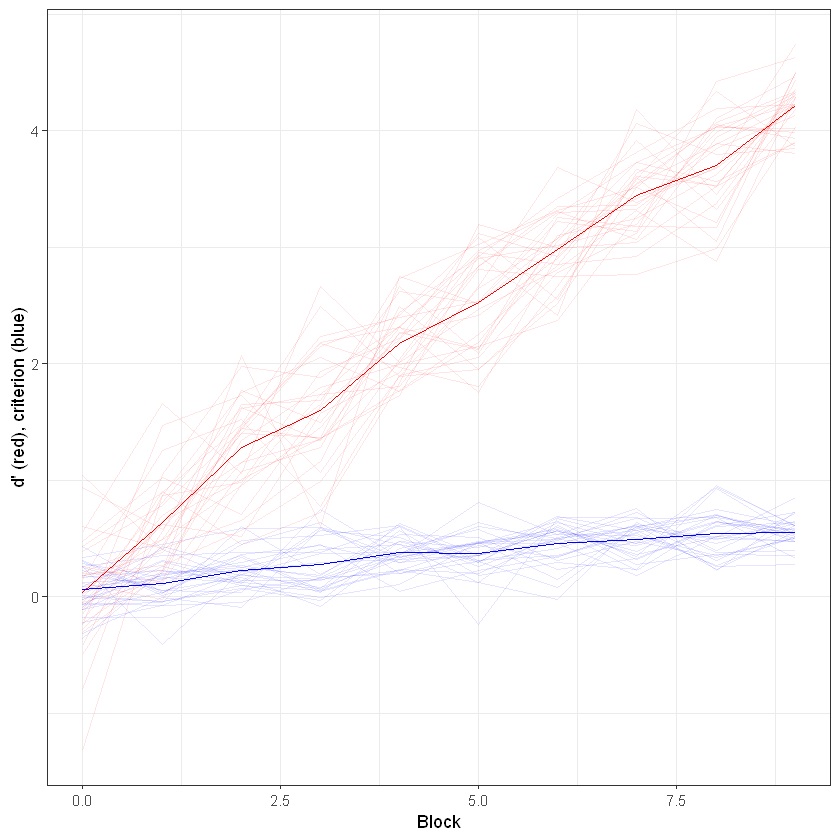

In [9]:
ggplot(dtable, aes(x = block, y = dprime, group = subject)) + geom_line(colour = 'red', alpha = .1) + geom_line(aes(y = criterion), colour = 'blue', alpha = .1) + 
  stat_summary(aes(group = NA), fun = 'mean', geom = 'line', colour = 'red') + 
  stat_summary(aes(y = criterion, group = NA), fun = 'mean', geom = 'line', colour = 'blue') + theme_bw() + labs(x = 'Block', y = "d' (red), criterion (blue)")


And that's it!